# Compare Arima results from Skforecast, pmdarima and statsforecast

In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)
import skforecast

print(skforecast.__version__)

/home/joaquin/Documents/GitHub/skforecast
0.20.0


In [2]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
from pmdarima import ARIMA as pmdarima_ARIMA
from skforecast.stats import Arima as skf_Arima
from statsforecast.models import ARIMA as statsforecast_Arima
import warnings
import timeit

In [3]:
# Datasets
# ==============================================================================
from fixtures_arima import datasets

In [19]:
# Benchmarking ARIMA implementations
# ==============================================================================
warnings.filterwarnings("ignore", message=".*force_all_finite.*")
warnings.filterwarnings("ignore", message=".*Non-stationary starting seasonal autoregressive.*")
warnings.filterwarnings("ignore", message=".*Too few observations to estimate starting parameters.*")
warnings.filterwarnings("ignore", message=".*Too few observations to estimate starting parameters for seasonal ARMA.*")

results = []
for key, value in datasets.items():
    data = value['data']
    m = value['seasonal_periods']
    order = value['order']
    seasonal_order = value['seasonal_order']
    steps_ahead = value['steps_ahead']
    name = key
    print(f"Dataset: {name}")

    # pmdarima
    try:
        print("    pmdarima...")
        start = timeit.default_timer()
        res = pmdarima_ARIMA(
            order=order,
            seasonal_order=seasonal_order + (m,),
            method = 'bfgs',
            maxiter = 500,
            suppress_warnings = False,
            trend = None,
            with_intercept = True,
        )
        res.fit(data)
        end = timeit.default_timer()
        elapsed_time_fit = end - start

        start = timeit.default_timer()
        predictions = res.predict(n_periods=steps_ahead).to_numpy()
        end = timeit.default_timer()
        elapsed_time_pred = end - start
        aic = res.aic()
    except Exception as e:
        warnings.warn(f"pmdarima ARIMA failed on dataset {name} with error: {e}")
        elapsed_time_fit = np.nan
        elapsed_time_pred = np.nan
        aic = np.nan
        predictions = [np.nan] * steps_ahead
    results.append([name, "pmdarima", elapsed_time_fit, elapsed_time_pred, aic, predictions])
    print(f"        time: {elapsed_time_fit + elapsed_time_pred:.2f} seconds")

    # skforecast
    print("    skforecast...")
    try:
        start = timeit.default_timer()
        res = skf_Arima(
            order=order,
            seasonal_order=seasonal_order,
            m=m,
            include_mean = True,
            transform_pars = True,
            method = "CSS-ML",
            n_cond = None,
            SSinit = "Gardner1980",
            optim_method = "BFGS",
            optim_kwargs = {"maxiter": 500},
        )
        res.fit(y=data, suppress_warnings=True)
        end = timeit.default_timer()
        elapsed_time_fit = end - start

        start = timeit.default_timer()
        predictions = res.predict(steps=steps_ahead)
        end = timeit.default_timer()
        elapsed_time_pred = end - start
        aic = res.aic_
    except Exception as e:
        warnings.warn(f"skforecast ARIMA failed on dataset {name} with error: {e}")
        elapsed_time_fit = np.nan
        elapsed_time_pred = np.nan
        aic = np.nan
        predictions = [np.nan] * steps_ahead
    results.append([name, "skforecast", elapsed_time_fit, elapsed_time_pred, aic, predictions])
    print(f"        time: {elapsed_time_fit + elapsed_time_pred:.2f} seconds")
    
    # statsforecast
    print("    statsforecast...")
    try:
        start = timeit.default_timer()
        res = statsforecast_Arima(
            order=order,
            seasonal_order=seasonal_order,
            season_length=m,
            include_mean = True,
            method = "CSS-ML",
        )
        res.fit(y=data)
        end = timeit.default_timer()
        elapsed_time_fit = end - start

        start = timeit.default_timer()
        predictions = res.predict(h=steps_ahead)['mean']
        end = timeit.default_timer()
        elapsed_time_pred = end - start
        aic = res.model_['aic']
    except Exception as e:
        warnings.warn(f"statsforecast ARIMA failed on dataset {name} with error: {e}")
        elapsed_time_fit = np.nan
        elapsed_time_pred = np.nan
        aic = np.nan
        predictions = [np.nan] * steps_ahead
    results.append([name, "statsforecast", elapsed_time_fit, elapsed_time_pred, aic, predictions])
    print(f"        time: {elapsed_time_fit + elapsed_time_pred:.2f} seconds")

Dataset: air_passengers
    pmdarima...
        time: 1.03 seconds
    skforecast...
        time: 0.43 seconds
    statsforecast...
        time: 0.05 seconds
Dataset: monthly_data
    pmdarima...
        time: 1.82 seconds
    skforecast...
        time: 0.12 seconds
    statsforecast...
        time: 0.06 seconds
Dataset: quarterly_data
    pmdarima...


/home/joaquin/miniconda3/envs/skforecast_20_py13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_9932/850295656.py:75: UserWarning: skforecast ARIMA failed on dataset quarterly_data with error: Non-stationary seasonal AR part from CSS
  warnings.warn(f"skforecast ARIMA failed on dataset {name} with error: {e}")
/home/joaquin/miniconda3/envs/skforecast_20_py13/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


        time: 1.66 seconds
    skforecast...
        time: nan seconds
    statsforecast...
        time: 0.09 seconds
Dataset: daily_data
    pmdarima...
        time: 1.27 seconds
    skforecast...
        time: 0.17 seconds
    statsforecast...
        time: 0.04 seconds
Dataset: hourly_data
    pmdarima...
        time: 8.44 seconds
    skforecast...
        time: 0.65 seconds
    statsforecast...
        time: 0.11 seconds
Dataset: no_seasonal_data
    pmdarima...


/home/joaquin/miniconda3/envs/skforecast_20_py13/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/joaquin/miniconda3/envs/skforecast_20_py13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


        time: 0.24 seconds
    skforecast...
        time: 0.12 seconds
    statsforecast...
        time: 0.11 seconds
Dataset: strong_seasonal
    pmdarima...
        time: 2.52 seconds
    skforecast...
        time: 0.26 seconds
    statsforecast...
        time: 0.07 seconds
Dataset: multi_seasonal
    pmdarima...


/home/joaquin/miniconda3/envs/skforecast_20_py13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


        time: 11.06 seconds
    skforecast...
        time: 0.79 seconds
    statsforecast...
        time: 0.19 seconds
Dataset: sunspots_data
    pmdarima...


/home/joaquin/miniconda3/envs/skforecast_20_py13/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/joaquin/miniconda3/envs/skforecast_20_py13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


        time: 9.66 seconds
    skforecast...
        time: 0.23 seconds
    statsforecast...
        time: 0.30 seconds
Dataset: co2_data
    pmdarima...
        time: 2.00 seconds
    skforecast...
        time: 0.81 seconds
    statsforecast...
        time: 0.12 seconds
Dataset: macrodata_data
    pmdarima...
        time: 0.11 seconds
    skforecast...
        time: 0.03 seconds
    statsforecast...
        time: 0.07 seconds
Dataset: nile_data
    pmdarima...
        time: 0.18 seconds
    skforecast...
        time: 0.02 seconds
    statsforecast...
        time: 0.03 seconds
Dataset: fuel_consumption
    pmdarima...
        time: 1.57 seconds
    skforecast...
        time: 0.35 seconds
    statsforecast...
        time: 0.22 seconds


In [20]:
# Results
# ==============================================================================
results_df = pd.DataFrame(
    results,
    columns=["dataset", "library", "time_fit", "time_pred", "aic", "predictions"]
)
results_df = results_df.set_index(['dataset'])
results_df

,library,time_fit,time_pred,aic,predictions
dataset,,,,,
air_passengers,pmdarima,1.019433,0.010615,1022.904236,"[447.39765478639623, 422.45058186250935, 454.3..."
air_passengers,skforecast,0.431859,0.000153,1021.837720,"[447.05675746637974, 421.8764069213296, 453.50..."
air_passengers,statsforecast,0.045023,0.000790,1021.007365,"[447.0757711641652, 421.9400011324278, 453.760..."
monthly_data,pmdarima,1.806158,0.011523,205.442889,"[140.03388251253494, 212.59105111863394, 217.3..."
monthly_data,skforecast,0.115077,0.000316,207.194538,"[137.63603149786462, 207.64714635385093, 213.1..."
monthly_data,statsforecast,0.054194,0.001561,206.141029,"[137.63461155341992, 207.64572518151454, 213.1..."
quarterly_data,pmdarima,1.653117,0.008625,157.099510,"[262.6032089172833, 116.12548510382481, -50.73..."
quarterly_data,skforecast,NaN,NaN,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan]"
quarterly_data,statsforecast,0.086236,0.000712,178.361447,"[235.66379845188953, 107.19456849797109, -55.6..."


In [21]:
# Diagnostics for a single dataset
# ==============================================================================
dataset_name = 'air_passengers'

data = datasets[dataset_name]['data']
m = datasets[dataset_name]['seasonal_periods']
order = datasets[dataset_name]['order']
seasonal_order = datasets[dataset_name]['seasonal_order']
steps_ahead = datasets[dataset_name]['steps_ahead']
name = dataset_name

res = skf_Arima(
    order=order,
    seasonal_order=seasonal_order,
    m=m,
    include_mean = True,
    transform_pars = True,
    method = "CSS-ML",
    n_cond = None,
    SSinit = "Gardner1980",
    optim_method = "BFGS",
    optim_kwargs = {"maxiter": 500},
)
res.fit(y=data, suppress_warnings=True)
predictions = res.predict(steps=steps_ahead)
predictions

array([447.05675747, 421.87640692, 453.50555544, 489.91243773,
       502.18849469, 564.23388311, 649.81418567, 636.71689994,
       538.92173947, 491.07235737, 422.8138238 , 464.74350053,
       479.57669159, 454.39634104, 486.02548957, 522.43237185,
       534.70842881, 596.75381723, 682.33411979, 669.23683406,
       571.44167359, 523.5922915 , 455.33375792, 497.26343465])

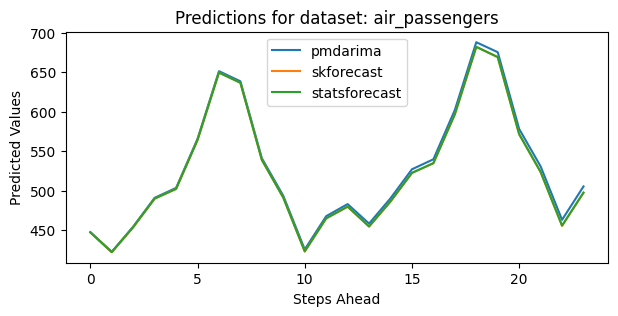

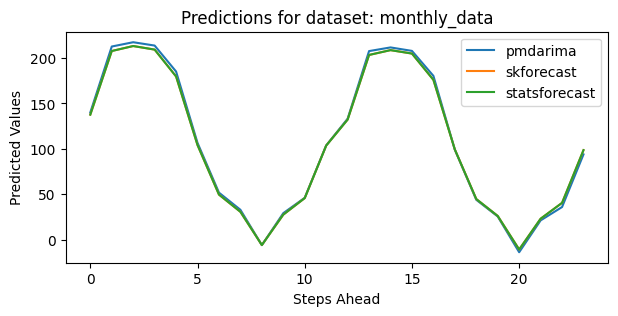

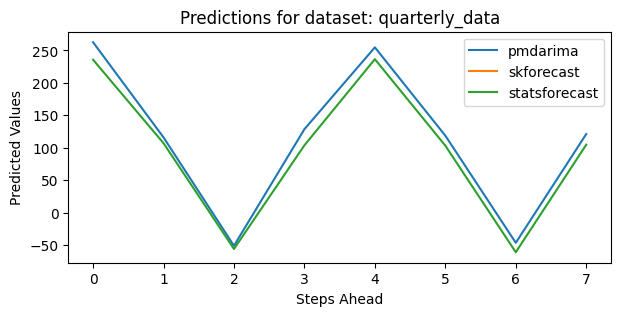

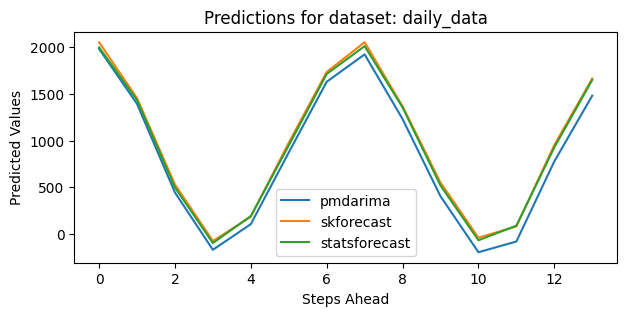

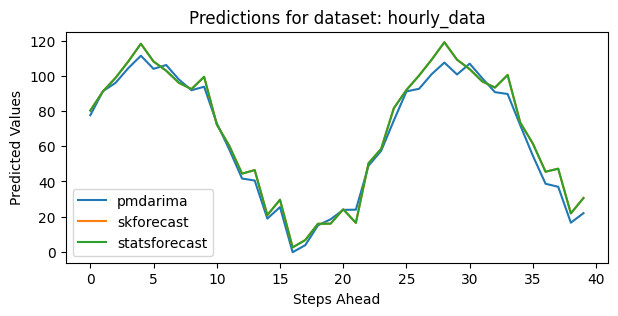

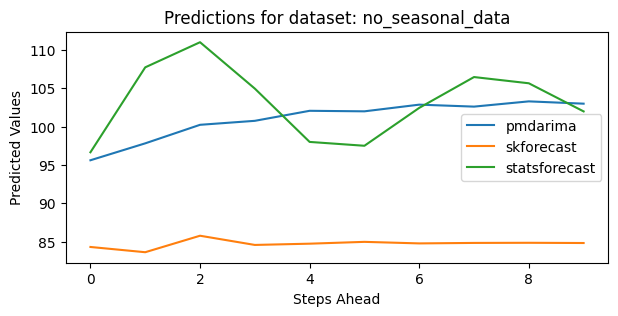

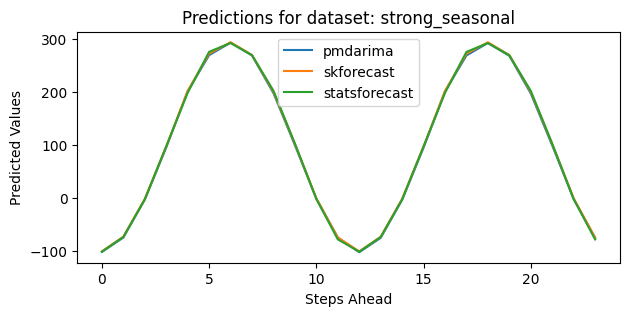

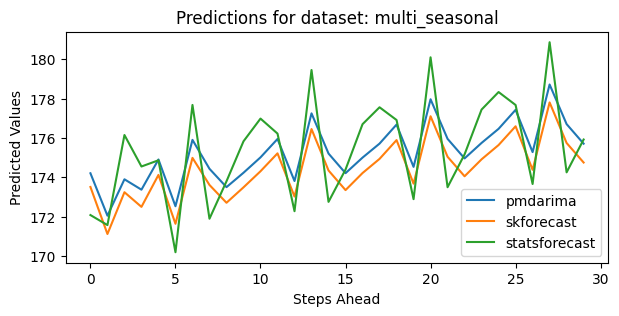

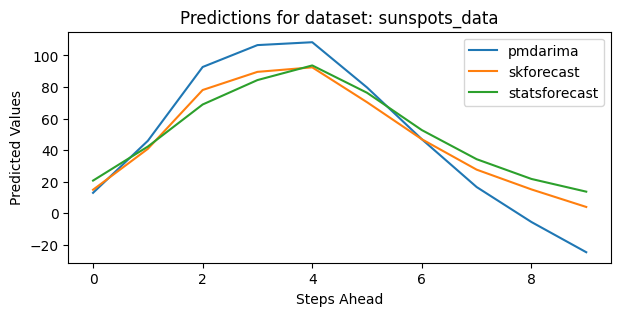

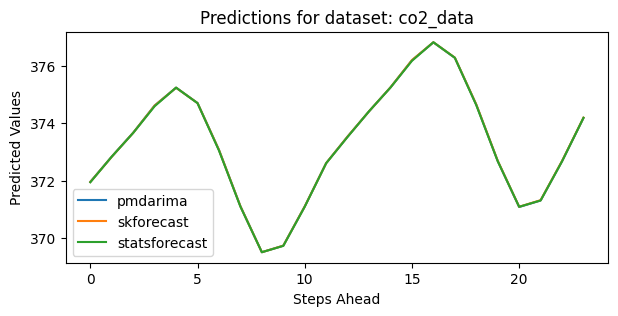

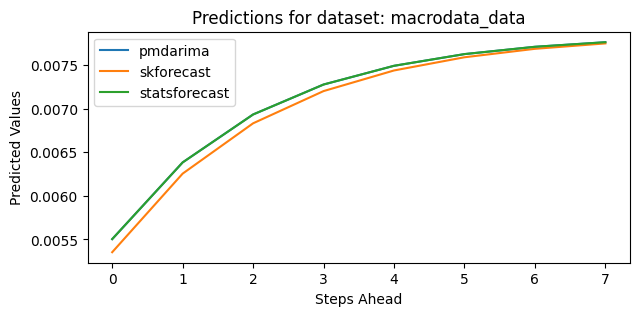

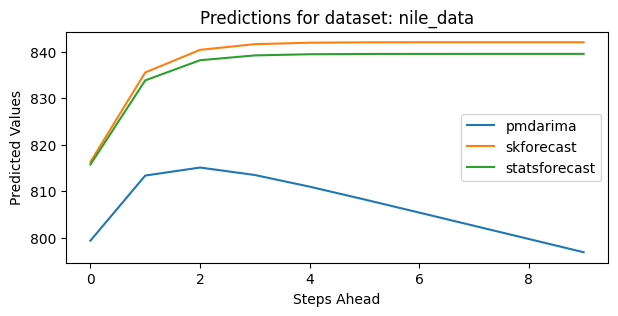

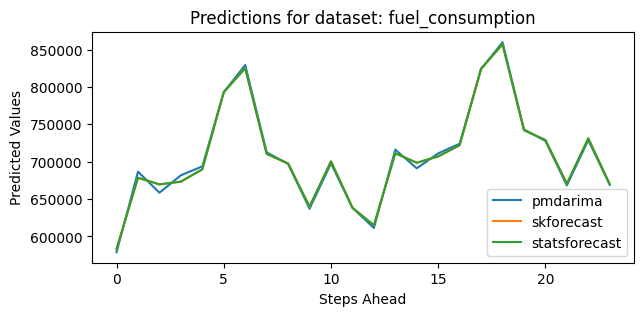

In [22]:
# Plot predictions
# ==============================================================================
import matplotlib.pyplot as plt

for dataset in results_df.index.unique():
    plt.figure(figsize=(7, 3))
    plt.title(f"Predictions for dataset: {dataset}")
    for _, row in results_df.loc[dataset].iterrows():
        plt.plot(
            range(len(row['predictions'])),
            row['predictions'],
            label=row['library']
        )
    plt.xlabel("Steps Ahead")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.show()

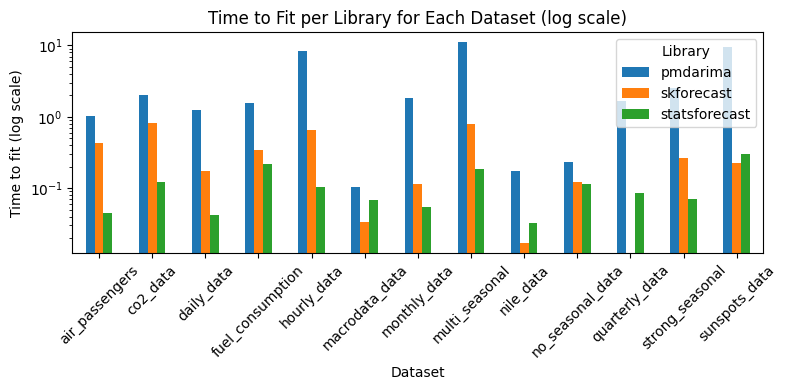

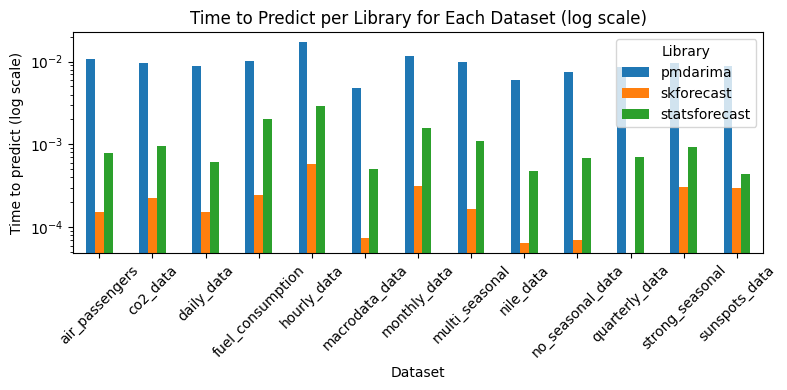

In [23]:
# Plot fitting times
# ==============================================================================
df_plot = results_df.pivot(columns="library", values="time_fit")
ax = df_plot.plot(kind="bar", figsize=(8,4))
plt.yscale("log") 
ax.set_ylabel("Time to fit (log scale)")
ax.set_xlabel("Dataset")
plt.title("Time to Fit per Library for Each Dataset (log scale)")
plt.xticks(rotation=45)
plt.legend(title="Library")
plt.tight_layout()
plt.show()

# Plot prediction times
# ==============================================================================
df_plot = results_df.pivot(columns="library", values="time_pred")
ax = df_plot.plot(kind="bar", figsize=(8,4))
plt.yscale("log") 
ax.set_ylabel("Time to predict (log scale)")
ax.set_xlabel("Dataset")
plt.title("Time to Predict per Library for Each Dataset (log scale)")
plt.xticks(rotation=45)
plt.legend(title="Library")
plt.tight_layout()
plt.show()